# Assignment 2 

In [5]:
import xarray as xr; from netCDF4 import Dataset, num2date
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np; import pandas as pd
import nc_time_axis
import cftime

Function for calculating weighted mean

In [6]:
def weighted_mean(data_da, dim, weights):
    r"""Computes the weighted mean.

    We can only do the actual weighted mean over the dimensions that
    ``data_da`` and ``weights`` share, so for dimensions in ``dim`` that aren't
    included in ``weights`` we must take the unweighted mean.

    This functions skips NaNs, i.e. Data points that are NaN have corresponding
    NaN weights.

    Args:
        data_da (xarray.DataArray):
            Data to compute a weighted mean for.
        dim (str | list[str]):
            dimension(s) of the dataarray to reduce over
        weights (xarray.DataArray):
            a 1-D dataarray the same length as the weighted dim, with dimension
            name equal to that of the weighted dim. Must be nonnegative.
    Returns:
        (xarray.DataArray):
            The mean over the given dimension. So it will contain all
            dimensions of the input that are not in ``dim``.
    Raises:
        (IndexError):
            If ``weights.dims`` is not a subset of ``dim``.
        (ValueError):
            If ``weights`` has values that are negative or infinite.
    """
    if isinstance(dim, str):
        dim = [dim]
    else:
        dim = list(dim)

    if not set(weights.dims) <= set(dim):
        dim_err_msg = (
            "`weights.dims` must be a subset of `dim`. {} are dimensions in "
            "`weights`, but not in `dim`."
        ).format(set(weights.dims) - set(dim))
        raise IndexError(dim_err_msg)
    else:
        pass  # `weights.dims` is a subset of `dim`

    if (weights < 0).any() or xr.ufuncs.isinf(weights).any():
        negative_weight_err_msg = "Weight must be nonnegative and finite"
        raise ValueError(negative_weight_err_msg)
    else:
        pass  # `weights` are nonnegative

    weight_dims = [
        weight_dim for weight_dim in dim if weight_dim in weights.dims
    ]

    if np.isnan(data_da).any():
        expanded_weights, _ = xr.broadcast(weights, data_da)
        weights_with_nans = expanded_weights.where(~np.isnan(data_da))
    else:
        weights_with_nans = weights

    mean_da = ((data_da * weights_with_nans).sum(weight_dims, skipna=True)
               / weights_with_nans.sum(weight_dims))
    other_dims = list(set(dim) - set(weight_dims))
    return mean_da.mean(other_dims, skipna=True)

In [7]:
dataset= '/projects/b1045/cmip/CMIP5/NCL_Practice/tas_Amon_CESM1-WACCM_rcp85_r2i1p1_200601-209912.nc'

In [8]:
dset = xr.open_dataset(dataset)


tas = dset.tas
lon = dset.lon
lat = dset.lat
time = dset.time

period = dset.sel(time=slice('2006-01-01', '2099-12-31'))

Text(0.0, 1.0, 'Global Monthly Mean Temperatures')

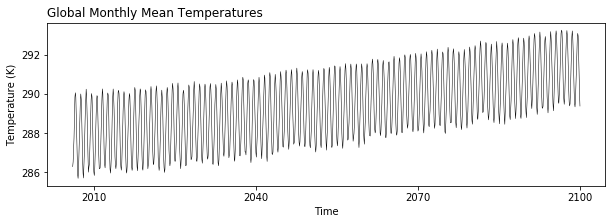

In [9]:
# Convert latitude to radians
latr = np.deg2rad(lat)

# Use the cosine of the converted latitudes as weights for the average
weights = np.cos(latr)

# Then take the weighted average of those using the weights we calculated earlier
lat_mean = weighted_mean(data_da= period.tas, dim = 'lat', weights =weights)
lat_glob_av = lat_mean.mean(dim ='lon')


plt.figure(figsize = (10,3))
plt.plot(lat_glob_av.time, lat_glob_av.data, linestyle='-', color='black', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Global Monthly Mean Temperatures', loc='left')


In [10]:
print(lat_glob_av)

<xarray.DataArray (time: 1128)>
array([286.281153, 286.525585, 287.096761, ..., 291.131755, 290.047806,
       289.380338])
Coordinates:
  * time     (time) object 2006-01-16 12:00:00 ... 2099-12-16 12:00:00
    height   float64 2.0


In [11]:
print(period)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 144, time: 1128)
Coordinates:
  * time       (time) object 2006-01-16 12:00:00 ... 2099-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 249.20734 249.21962 ... 255.58525
Attributes:
    institution:                  NSF/DOE NCAR (National Center for Atmospher...
    institute_id:                 NSF-DOE-NCAR
    experiment_id:                rcp85
    source:                       CESM1-WACCM
    model_id:                     CESM1-WACCM
    forcing:                      Sl GHG SS Ds SA BC MD OC Oz AA
    parent_experiment_id:         historical
    parent_experiment_rip:       

# Part 2

In [12]:
year_av = lat_glob_av.groupby('time.year').mean(dim ='time')

Create Baseline 

In [13]:
baseline = year_av.sel(year = slice('2006-01-01','2035-12-31'))
baseline_av = baseline.mean(dim = 'year')
print(baseline_av)

<xarray.DataArray ()>
array(288.237086)
Coordinates:
    height   float64 2.0


Calculate Temperature Anomalies from Baseline 

In [14]:
temp_anom = year_av - baseline_av
print(temp_anom.data)

[-0.28343621 -0.40230747 -0.26605783 -0.29221911 -0.33390738 -0.16578088
 -0.09231852 -0.2060767  -0.05096819 -0.19130781 -0.20469806 -0.05772119
 -0.05845633 -0.07664291  0.05080237  0.04244756 -0.1850521  -0.06848746
  0.15713788  0.15224798 -0.04873942  0.13605334  0.1887498   0.21489027
  0.28409181  0.24880944  0.16281984  0.25553617  0.42641518  0.38073971
  0.37786704  0.55238698  0.45581779  0.45050848  0.54744182  0.59064959
  0.61427104  0.62513107  0.78803123  0.96908087  0.95628599  0.98904564
  0.94710545  0.96265114  0.8734616   0.91292379  1.07609791  1.00976402
  1.11681465  1.0336625   1.19095688  1.29720077  1.27131764  1.17293258
  1.32751748  1.5452401   1.55642949  1.47228583  1.48701074  1.59921357
  1.62250695  1.79923118  1.82703573  1.72485949  1.78256652  1.85494547
  2.04715074  1.91915376  1.90564932  2.01892924  2.07111258  1.94501537
  1.98802631  2.0958586   2.27785577  2.45971188  2.49190768  2.26222544
  2.26485367  2.31690196  2.34147547  2.48891967  2

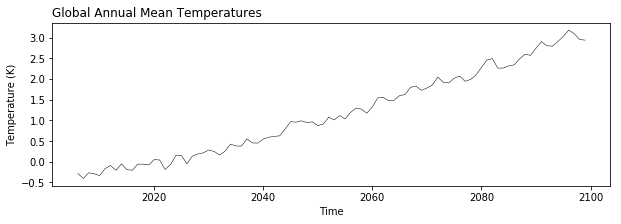

In [15]:
plt.figure(figsize = (10,3))
plt.plot(temp_anom.year, temp_anom.data, linestyle='-', color='black', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Global Annual Mean Temperatures', loc='left')
fig2=plt.savefig('assign2_anom')

# Both figures on one plot

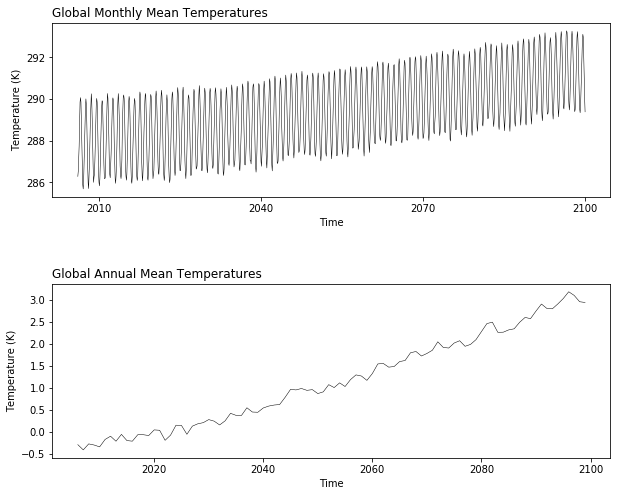

In [16]:
fig = plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(lat_glob_av.time, lat_glob_av.data, linestyle='-', color='black', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Global Monthly Mean Temperatures', loc='left')
plt.subplot(212)
plt.plot(temp_anom.year, temp_anom.data, linestyle='-', color='black', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Global Annual Mean Temperatures', loc='left')

fig.subplots_adjust(hspace=.5)
